## Movie Recommendation System Using Collaborative Filtering

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
movies = pd.read_csv('data/movies_metadata.csv')
ratings = pd.read_csv('data/ratings_small.csv')#############33
#links = pd.read_csv('data/links.csv')
#keywords = pd.read_csv('data/keywords.csv')
#credits = pd.read_csv('data/credits.csv')

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
movies

,movieId,title,genres,vote_average,vote_count
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",7.7,5415.0
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,2413.0
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",6.5,92.0
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",6.1,34.0
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",5.7,173.0
...,...,...,...,...,...
45461,439050,Subdue,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",4.0,1.0
45462,111109,Century of Birthing,"[{'id': 18, 'name': 'Drama'}]",9.0,3.0
45463,67758,Betrayal,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",3.8,6.0
45464,227506,Satan Triumphant,[],0.0,0.0


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [5]:
# Select relevant columns
movies = movies[['id', 'title', 'genres', 'vote_average', 'vote_count']]

# Convert vote_average and vote_count to numeric
movies['vote_average'] = pd.to_numeric(movies['vote_average'], errors='coerce')
movies['vote_count'] = pd.to_numeric(movies['vote_count'], errors='coerce')

# Drop rows with missing values
movies.dropna(subset=['id', 'title', 'vote_average', 'vote_count'], inplace=True)

# Ensure movieId is integer
movies['id'] = movies['id'].astype(int)

movies.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_5384\1921634674.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['vote_average'] = pd.to_numeric(movies['vote_average'], errors='coerce')
C:\Users\Asus\AppData\Local\Temp\ipykernel_5384\1921634674.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['vote_count'] = pd.to_numeric(movies['vote_count'], errors='coerce')
c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A valu

,id,title,genres,vote_average,vote_count
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",7.7,5415.0
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,2413.0
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",6.5,92.0
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",6.1,34.0
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",5.7,173.0


In [6]:
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
"""# Give the same column name as in ratings dataframe
movies.rename(columns={'id': 'movieId'}, inplace=True)

# Create the user-item matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Fill missing values with zeros (optional, depending on the approach)
user_item_matrix.fillna(0, inplace=True)

user_item_matrix.head()"""

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The user-movie pivot table will look mostly empty since the users do not have to rate all the movies. Now let's check the distribution of ratings and eliminate the movies with less number of ratings and the users who did not rate a lot of movies which has less significance.

In [8]:
movies.rename(columns={'id': 'movieId'}, inplace=True)
merged_df = pd.merge(ratings, movies, on='movieId')
merged_df.head()

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,userId,movieId,rating,timestamp,title,genres,vote_average,vote_count
0,1,1371,2.5,1260759135,Rocky III,"[{'id': 18, 'name': 'Drama'}]",6.6,894.0
1,4,1371,4.0,949810302,Rocky III,"[{'id': 18, 'name': 'Drama'}]",6.6,894.0
2,7,1371,3.0,851869160,Rocky III,"[{'id': 18, 'name': 'Drama'}]",6.6,894.0
3,19,1371,4.0,855193404,Rocky III,"[{'id': 18, 'name': 'Drama'}]",6.6,894.0
4,21,1371,3.0,853852263,Rocky III,"[{'id': 18, 'name': 'Drama'}]",6.6,894.0


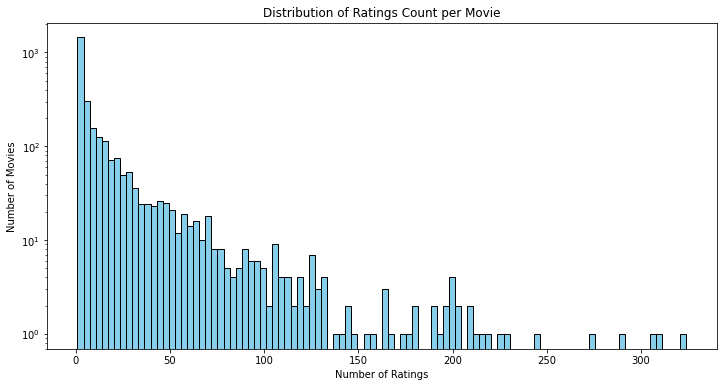

In [9]:
# Calculate the number of ratings per movie
ratings_count = merged_df.groupby('title').size().sort_values(ascending=False)

# Plot the distribution of ratings count
plt.figure(figsize=(12, 6))
plt.hist(ratings_count, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings Count per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.yscale('log')  # Use log scale for better visualization
plt.show()

As it can be seen here, most of the movies are rated close to 0 times. Let's try again after removing these movies.

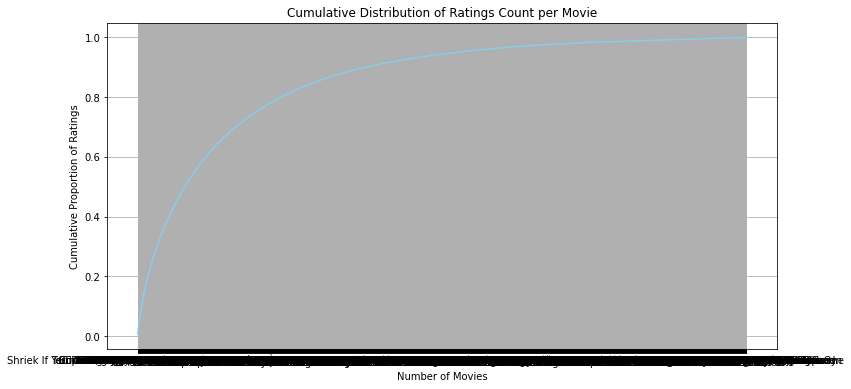

In [10]:
# Calculate the cumulative distribution of ratings
cumulative_ratings = ratings_count.cumsum() / ratings_count.sum()

# Plot the cumulative distribution
plt.figure(figsize=(12, 6))
plt.plot(cumulative_ratings, color='skyblue')
plt.title('Cumulative Distribution of Ratings Count per Movie')
plt.xlabel('Number of Movies')
plt.ylabel('Cumulative Proportion of Ratings')
plt.grid(True)
plt.show()

In [11]:
# Calculate the number of ratings per movie
ratings_count = merged_df.groupby('title').size().sort_values(ascending=False)

# Calculate the cumulative distribution of ratings
cumulative_ratings = ratings_count.cumsum() / ratings_count.sum()

# Determine the 90% coverage threshold
threshold_90_percent = cumulative_ratings[cumulative_ratings >= 0.90].index[0]
ratings_threshold = ratings_count[threshold_90_percent]

print(f'Threshold for minimum number of ratings: {ratings_threshold}')

# Filter movies that have more than the threshold number of ratings
popular_movies = ratings_count[ratings_count > ratings_threshold].index

# Filter the merged dataframe
filtered_df = merged_df[merged_df['title'].isin(popular_movies)]
filtered_df.shape

Threshold for minimum number of ratings: 8


(40098, 8)

From more than 26 million ratings only approximately 10 million of them were to a movie rated more than 1746 times. So we eliminated those movies and ratings for computation efficiency and accuracy purposes.  

### User Movie Dataframe

In [8]:
# Removing unnecessary/corrupted columns for runtime
#movies = movies.drop(columns=['homepage', 'poster_path', 'spoken_languages', 'original_title', 'video', 'tagline'])

In [12]:
movies

,movieId,title,genres,vote_average,vote_count
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",7.7,5415.0
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",6.9,2413.0
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",6.5,92.0
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",6.1,34.0
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",5.7,173.0
...,...,...,...,...,...
45461,439050,Subdue,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",4.0,1.0
45462,111109,Century of Birthing,"[{'id': 18, 'name': 'Drama'}]",9.0,3.0
45463,67758,Betrayal,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",3.8,6.0
45464,227506,Satan Triumphant,[],0.0,0.0


In [13]:
"""movies.rename(columns={'id': 'movieId'}, inplace=True)
movies['movieId'] = pd.to_numeric(movies['movieId'], errors='coerce')
movies_w_ratings = movies.merge(ratings, how="left", on="movieId")
movies_w_ratings"""

'movies.rename(columns={\'id\': \'movieId\'}, inplace=True)\nmovies[\'movieId\'] = pd.to_numeric(movies[\'movieId\'], errors=\'coerce\')\nmovies_w_ratings = movies.merge(ratings, how="left", on="movieId")\nmovies_w_ratings'

In [14]:
merged_df["title"].nunique() # of unique movies

2794

In [15]:
merged_df.shape[0] # of total ratings

44994

In [16]:
# Create the user-item matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Fill missing values with zeros (optional, depending on the approach)
user_item_matrix.fillna(0, inplace=True)

user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User-Based Collaborative Filtering

In [20]:
# Calculate user similarity matrix
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

user_similarity_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086


In [21]:
def get_user_based_recommendations(user_id, user_item_matrix, user_similarity_df, num_recommendations=5):
    # Get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]
    
    # Calculate the weighted sum of ratings from similar users
    similar_users = user_similarity_df[user_id]
    weighted_ratings = user_item_matrix.T.dot(similar_users)
    
    # Exclude movies the user has already rated
    unrated_movies = user_ratings[user_ratings == 0].index
    recommendations = weighted_ratings[unrated_movies].sort_values(ascending=False)
    
    return recommendations.head(num_recommendations)

In [22]:
# Example: Get recommendations for user 1
print(get_user_based_recommendations(1, user_item_matrix, user_similarity_df))

movieId
260     32.148441
296     31.120171
1196    30.273608
318     29.678818
1198    28.316833
dtype: float64


## Item-Based Collaborative Filtering

In [23]:
# Transpose the user-item matrix to item-user matrix
item_user_matrix = user_item_matrix.T

# Calculate item similarity matrix
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

item_similarity_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.055829,0.031902,0.079755,0.079755,0.079755,0.079755,0.079755,0.0,0.0,0.055829
2,0.394511,1.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.000000,0.055038,0.068797,0.082557,0.082557,0.137594,0.068797,0.0,0.0,0.000000
3,0.306516,0.217492,1.000000,0.177012,0.370732,0.247499,0.435648,0.127574,0.306717,0.191255,...,0.000000,0.000000,0.000000,0.116226,0.116226,0.000000,0.000000,0.0,0.0,0.000000
4,0.133614,0.164651,0.177012,1.000000,0.179556,0.072518,0.184626,0.501513,0.254630,0.111447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,0.245102,0.278476,0.370732,0.179556,1.000000,0.272645,0.388476,0.194113,0.367941,0.246846,...,0.000000,0.176845,0.000000,0.117897,0.117897,0.000000,0.000000,0.0,0.0,0.000000


In [24]:
def get_item_based_recommendations(user_id, user_item_matrix, item_similarity_df, num_recommendations=5):
    # Get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]
    
    # Calculate the weighted sum of ratings from similar items
    weighted_ratings = item_similarity_df.dot(user_ratings)
    
    # Exclude movies the user has already rated
    unrated_movies = user_ratings[user_ratings == 0].index
    recommendations = weighted_ratings[unrated_movies].sort_values(ascending=False)
    
    return recommendations.head(num_recommendations)

In [25]:
# Example: Get recommendations for user 1
print(get_item_based_recommendations(1, user_item_matrix, item_similarity_df))

movieId
1387    17.151593
1266    16.929879
2194    16.615351
1214    16.498407
3108    16.457080
dtype: float64


The similarity distance is very low for the recommended movies. Let's add clustering to the algorithm for movies to increase accuracy.

## Clustering